# Appendix: MLP

Here we will quickly use the hyperparameters identified in our LSTM modeling to build a simpler MLP model. This will help benchmark performance

### Setup

In [25]:
import datetime as dt
import gc
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation
from keras.regularizers import L1L2

plt.style.use('ggplot')

#### Define helper functions

In [26]:
# Function to replace every NULL column with the mean from the training set (Naive Bayes)
def replace_nans_mean(df, split_date):
    split_idx = np.max(df.loc[df['date']<split_date].index.values)
    df_cp = df.copy()
    for col in df_cp.columns:
        if col == 'date':
            continue
        naive_estimate = df_cp.loc[:split_idx, col].mean()
        df_cp.loc[pd.isnull(df_cp[col]), col] = naive_estimate
        
    return df_cp

In [27]:
# Select features for RNN, along with target. Specifically, remove averages.
features = [
    'target',
    'date',
    'player_played',
    'player_home',
    'betting_over_under_line',
    'betting_spread',
    'weather_temperature',
    'weather_wind_mph',
    'weather_humidity',
    'weather_inclement',
    'defense_fumbles_forced_moving_avg_1',
    'defense_fumbles_forced_moving_avg_3',
    'defense_fumbles_forced_moving_avg_5',
    'defense_interceptions_moving_avg_1',
    'defense_interceptions_moving_avg_3',
    'defense_interceptions_moving_avg_5',
    'defense_pass_yards_allowed_moving_avg_1',
    'defense_pass_yards_allowed_moving_avg_3',
    'defense_pass_yards_allowed_moving_avg_5',
    'defense_rush_yards_allowed_moving_avg_1',
    'defense_rush_yards_allowed_moving_avg_3',
    'defense_rush_yards_allowed_moving_avg_5',
    'defense_sacks_moving_avg_1',
    'defense_sacks_moving_avg_3',
    'defense_sacks_moving_avg_5',
    'defense_points_allowed_moving_avg_1',
    'defense_points_allowed_moving_avg_3',
    'defense_points_allowed_moving_avg_5',
    'twitter_pct_player_tweets',
    'twitter_pct_opponent_tweets',
    'twitter_count_player_swing_1_3',
    'twitter_count_opponent_swing_1_3',
    'twitter_player_net_sentiment',
    'twitter_opponent_net_sentiment',
    'twitter_player_pct_neutral',
    'twitter_opponent_pct_neutral',
    'twitter_net_sentiment_player_swing_1_3',
    'twitter_net_sentiment_opponent_swing_1_3',
    'twitter_pct_neutral_player_swing_1_3',
    'twitter_pct_neutral_opponent_swing_1_3',
]

# Define data on which to split train and test sets
split_date = pd.Timestamp(2012,5,1)

## Tom Brady

In [28]:
# Read in data
brady = pd.read_csv('../data/data_final/final/features_raw/brady.csv')

brady = brady.loc[:, features]
brady['date'] = pd.to_datetime(brady['date'])

In [29]:
split_date = pd.Timestamp(2012,5,1)        
brady = replace_nans_mean(brady, split_date)

In [30]:
# Train + test set indices
train_idx = brady.loc[brady['date']<split_date].index.values
test_idx = brady.loc[brady['date']>split_date].index.values

# Scale Features
brady.drop('date', axis=1, inplace=True)
scaler = MinMaxScaler()
scaler.fit(brady)
brady = scaler.transform(brady)

# Train + test sets
train, test = brady[train_idx], brady[test_idx]

In [31]:
# Create train and test sets
X_train, y_train = train[:,1:], train[:,0]
X_test, y_test = test[:,1:], test[:,0]

In [32]:
# Invert scaling of y for testing comparison
y_inv = np.concatenate((y_test.reshape(len(y_test),1), test[:,1:]), axis=1)
y_inv = scaler.inverse_transform(y_inv)
y_inv = y_inv[:,0]

In [33]:
%%time
# Build networks. Loop n times to deal with randomness.
n_loops = 10
rmses, maes = [], []
best_rmse, best_mae = 100, 100
best_model = None
best_preds = []

for i in range(0, n_loops):
    model = Sequential()
    model.add(Dense(100, input_dim=X_train.shape[1], bias_regularizer=L1L2(0.01,0.01)))
    model.add(Activation('relu'))
    model.add(Dropout(0.3))
    model.add(Dense(20))
    model.add(Activation('relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    
    # Fit network
    mlp_model = model.fit(X_train, y_train, epochs=250, batch_size=5, validation_data = (X_test, y_test), verbose=0, shuffle=False)
    
    # Make predictions for test set
    preds = model.predict(X_test)
    
    # Invert scaling for preds
    preds_inv = np.concatenate((preds, test[:,1:]), axis=1)
    preds_inv = scaler.inverse_transform(preds_inv)
    preds_inv = preds_inv[:,0]
    
    # Calculate RMSE and MAE
    rmses.append(np.sqrt(mean_squared_error(y_inv, preds_inv)))
    maes.append(mean_absolute_error(y_inv, preds_inv))
    
    if maes[i] < best_mae:
        best_rmse = rmses[i]
        best_mae = maes[i]
        best_model = mlp_model
        best_preds = preds_inv
        
    gc.collect()
    

CPU times: user 58 s, sys: 6.55 s, total: 1min 4s
Wall time: 46.5 s


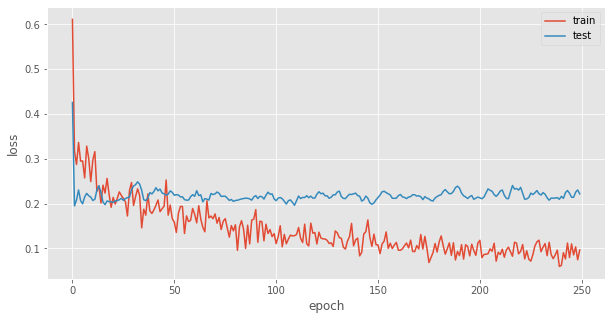

In [34]:
# Plot loss curve for best model
plt.rcParams['figure.figsize'] = (10, 5)

plt.plot(best_model.history['loss'], label='train')
plt.plot(best_model.history['val_loss'], label='test')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [35]:
# Print RMSES and MAES
print('Best RMSE: {:.2f}'.format(best_rmse))
print('Best MAE: {:.2f}'.format(best_mae))
print('Average RMSE: {:.2f}'.format(np.mean(rmses)))
print('Average MAE: {:.2f}'.format(np.mean(maes)))

Best RMSE: 7.01
Best MAE: 5.41
Average RMSE: 7.41
Average MAE: 6.13


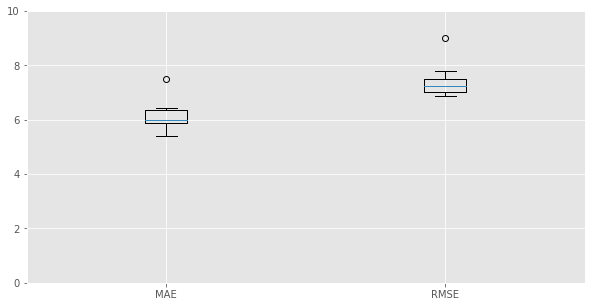

In [36]:
plt.boxplot([maes, rmses])
plt.xticks([1,2],['MAE', 'RMSE'])
plt.ylim(0,10)
plt.show()

Text(0.5, 1.0, 'Tom Brady Fantasy Points 2012, Predicted vs Actual')

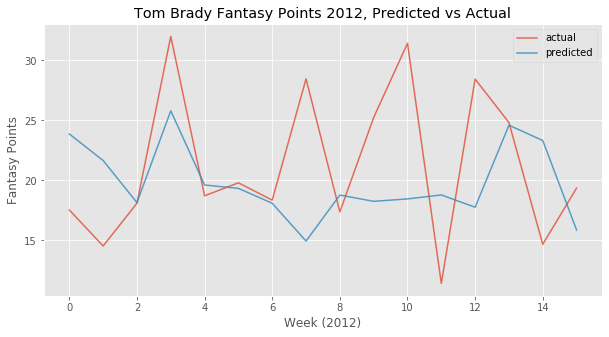

In [37]:
plt.rcParams['figure.figsize'] = (10, 5)
fig, ax = plt.subplots()
plot1 = ax.plot(y_inv, alpha = 0.8, label='actual')
plot1 = ax.plot(best_preds, alpha = 0.8, label='predicted')
ax.legend()
plt.xlabel('Week (2012)')
plt.ylabel('Fantasy Points')
plt.title('Tom Brady Fantasy Points 2012, Predicted vs Actual')

## LeSean McCoy

In [38]:
# Read in data
mccoy = pd.read_csv('../data/data_final/final/features_raw/mccoy.csv')
mccoy = mccoy.loc[:, features]
mccoy['date'] = pd.to_datetime(mccoy['date'])
mccoy = replace_nans_mean(mccoy, split_date)

In [39]:
# Train + test set indices
mccoy_played_only = mccoy.loc[mccoy['player_played']==1].copy().reset_index(drop=True)
train_idx = mccoy_played_only.loc[mccoy['date']<split_date].index.values
test_idx = mccoy_played_only.loc[mccoy_played_only['date']>split_date].index.values

# Scale Features
mccoy.drop('date', axis=1, inplace=True)
scaler = MinMaxScaler()
scaler.fit(mccoy)
mccoy = scaler.transform(mccoy)

# Train + test sets
train, test = mccoy[train_idx], mccoy[test_idx]
train, test = train[train[:,0]!=0], test[test[:,0]!=0]

In [40]:
# Create train and test sets
X_train, y_train = train[:,1:], train[:,0]
X_test, y_test = test[:,1:], test[:,0]

In [41]:
# Invert scaling of y for testing comparison
y_inv = np.concatenate((y_test.reshape(len(y_test),1), test[:,1:]), axis=1)
y_inv = scaler.inverse_transform(y_inv)
y_inv = y_inv[:,0]

In [42]:
%%time
# Build networks. Loop n times to deal with ranodmness.
n_loops = 25
rmses, maes = [], []
best_rmse, best_mae = 100, 100
best_model = None
best_preds = []

for i in range(0, n_loops):
    model = Sequential()
    model.add(Dense(30, input_dim=X_train.shape[1], bias_regularizer=L1L2(0.01,0.01)))
    model.add(Activation('relu'))
    model.add(Dropout(0.3))
    model.add(Dense(20))
    model.add(Activation('relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    
    # Fit network
    mlp_model = model.fit(X_train, y_train, epochs=20, batch_size=5, validation_data = (X_test, y_test), verbose=0, shuffle=False)
    
    # Make predictions for test set
    preds = model.predict(X_test)
    
    # Invert scaling for preds
    preds_inv = np.concatenate((preds, test[:,1:]), axis=1)
    preds_inv = scaler.inverse_transform(preds_inv)
    preds_inv = preds_inv[:,0]
    
    # Calculate RMSE and MAE
    rmses.append(np.sqrt(mean_squared_error(y_inv, preds_inv)))
    maes.append(mean_absolute_error(y_inv, preds_inv))
    
    if maes[i] < best_mae:
        best_rmse = rmses[i]
        best_mae = maes[i]
        best_model = mlp_model
        best_preds = preds_inv
        
    gc.collect()


CPU times: user 1min 25s, sys: 4.97 s, total: 1min 30s
Wall time: 1min 24s


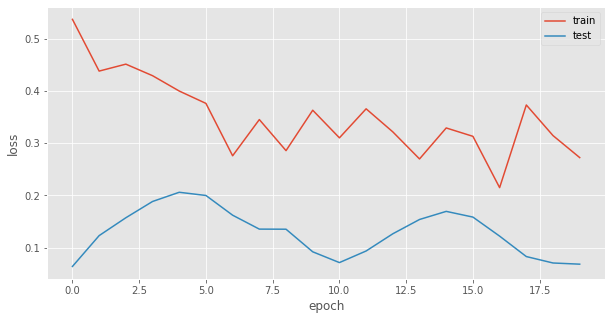

In [43]:
# Plot loss curve for best model
plt.rcParams['figure.figsize'] = (10, 5)

plt.plot(best_model.history['loss'], label='train')
plt.plot(best_model.history['val_loss'], label='test')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [44]:
# Print RMSES and MAES
print('Best RMSE: {:.2f}'.format(best_rmse))
print('Best MAE: {:.2f}'.format(best_mae))
print('Average RMSE: {:.2f}'.format(np.mean(rmses)))
print('Average MAE: {:.2f}'.format(np.mean(maes)))

Best RMSE: 2.67
Best MAE: 2.14
Average RMSE: 4.77
Average MAE: 4.02


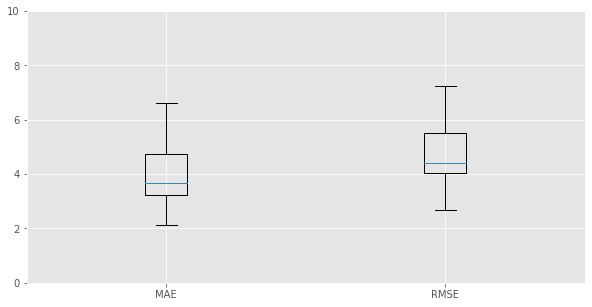

In [45]:
plt.boxplot([maes, rmses])
plt.xticks([1,2],['MAE', 'RMSE'])
plt.ylim((0,10))
plt.show()

Text(0.5, 1.0, 'LeSean McCoy Fantasy Points 2012, Predicted vs Actual')

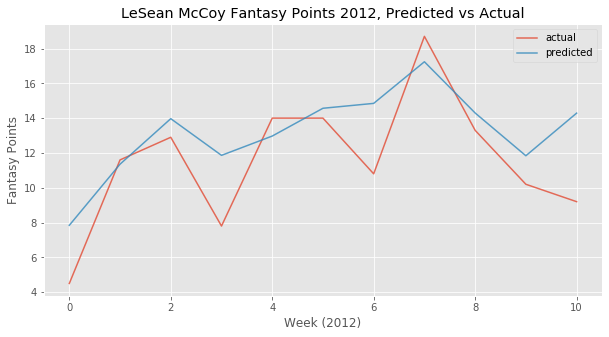

In [46]:
plt.rcParams['figure.figsize'] = (10, 5)
fig, ax = plt.subplots()
plot1 = ax.plot(y_inv, alpha = 0.8, label='actual')
plot1 = ax.plot(best_preds, alpha = 0.8, label='predicted')
ax.legend()
plt.xlabel('Week (2012)')
plt.ylabel('Fantasy Points')
plt.title('LeSean McCoy Fantasy Points 2012, Predicted vs Actual')